# Práctica 6

Integrantes:
- Angel Martinez
- Alejandra Sarria
- Juan Segura

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit


# Diseño de los gráficos
sns.set()
sns.set_context("paper")
sns.set_palette("colorblind")

## Calibración

In [33]:
def cargar_datos(carpeta, archivo_nombre):
    p = pd.read_csv(f"Practica6_datos/{carpeta}/{archivo_nombre}.csv", sep='\t')
    t = np.array(p["Time (s)"])
    I = np.array(p["Illuminance (lx)"])

    return t, I

def calibracion(carpeta, archivo_nombre):
    t, I = cargar_datos(carpeta, archivo_nombre)
    I_mean = np.mean(I)
    I_std = np.std(I)

    fig, ax = plt.subplots(figsize= (10, 5))
    ax.plot(t, I)
    ax.set_xlabel("Tiempo (s)", fontsize= 15)
    ax.set_ylabel("Iluminancia (lx)", fontsize= 15)

    # Linea del promedio
    ax.plot(t, np.ones(len(t))*I_mean, color='red', linestyle='--', linewidth='2', label=f"Promedio = {I_mean:.2f} lx")
    
    # Desviacion estandar
    ax.plot(t, np.ones(len(t))*(I_mean + I_std), color='orange', linestyle=':', alpha=0.7)
    ax.plot(t, np.ones(len(t))*(I_mean - I_std), color='orange', linestyle=':', alpha=0.7)
    plt.fill_between(x=t, y1=I_mean - I_std, y2= I_mean + I_std, alpha=0.2, color='yellow', label='Desviación estándar')

    ax.grid(True)
    plt.tight_layout()
    plt.savefig(f'calibracion_{archivo_nombre}.pdf')
    plt.show()

    print(f"Error relativo porcentual: {(I_std / I_mean * 100):.2f}%")

    return I_mean, I_std

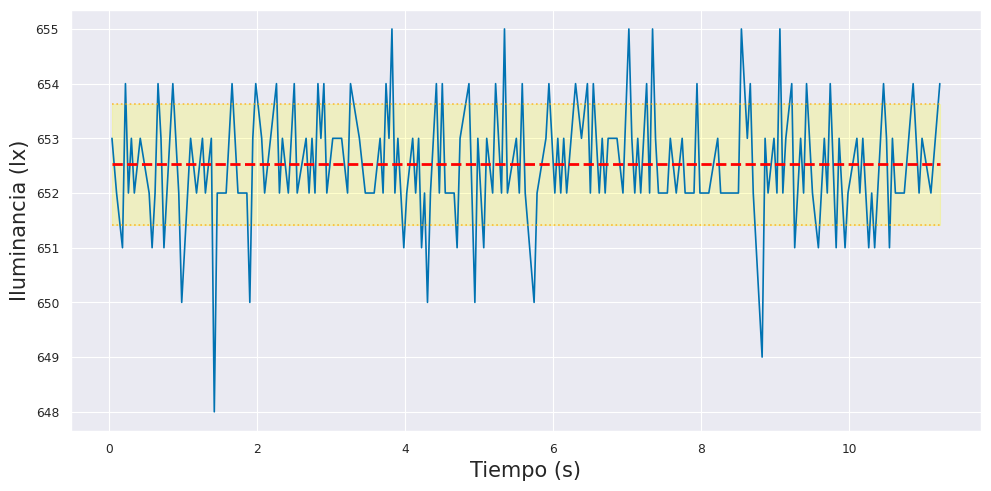

Error relativo porcentual: 0.17%


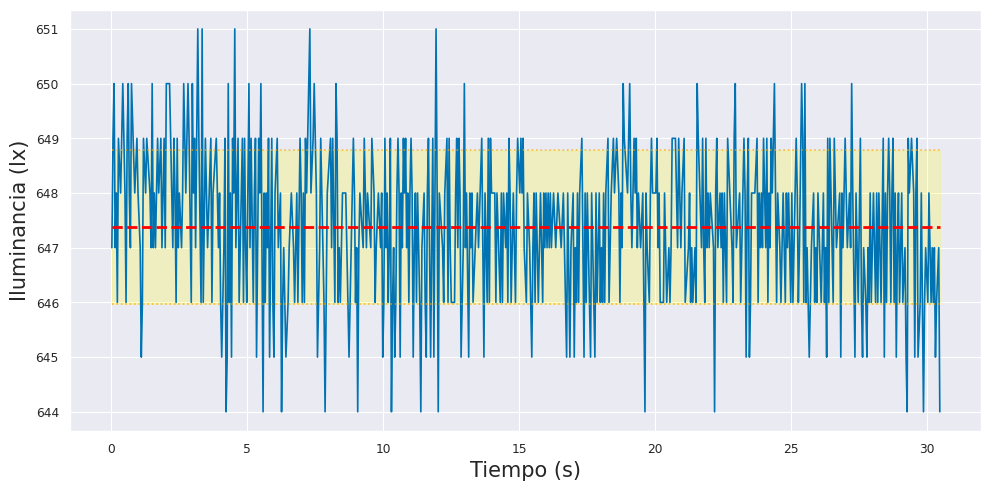

Error relativo porcentual: 0.22%


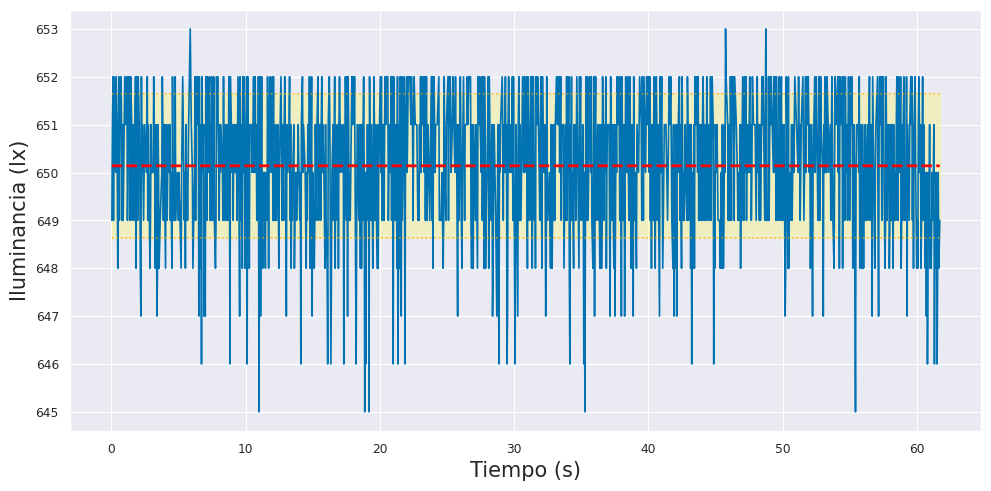

Error relativo porcentual: 0.23%


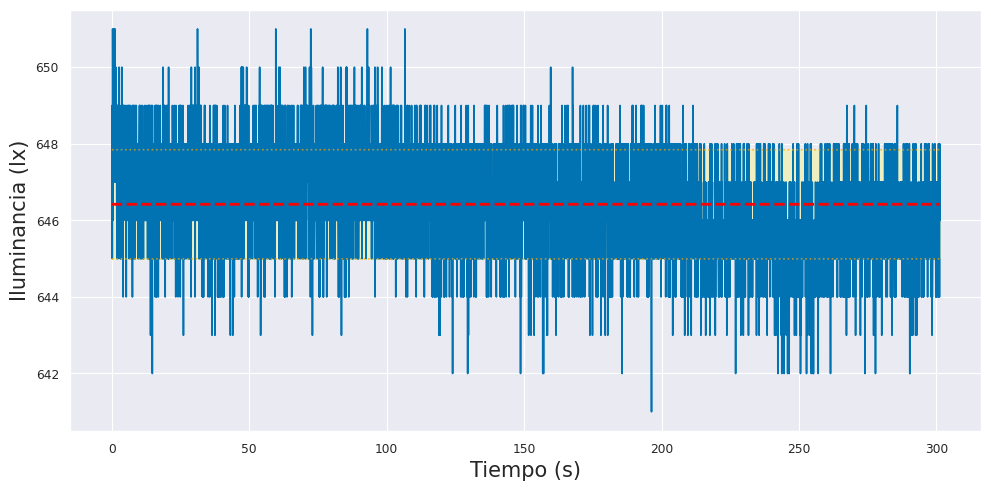

Error relativo porcentual: 0.22%


In [34]:
T_calibracion = ["10seg", "30seg", "1min", "5min"]

for i in T_calibracion:
    calibracion("Calibracion", i)

## Ley de Malus

\begin{equation}
    I = I_{0}\cos^2(\theta + \alpha)
\end{equation}

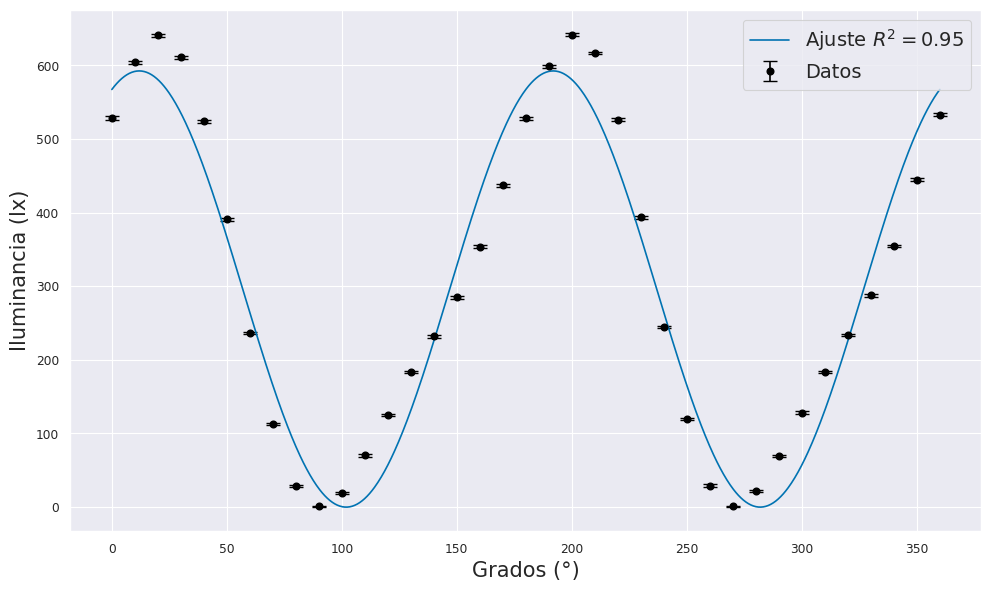

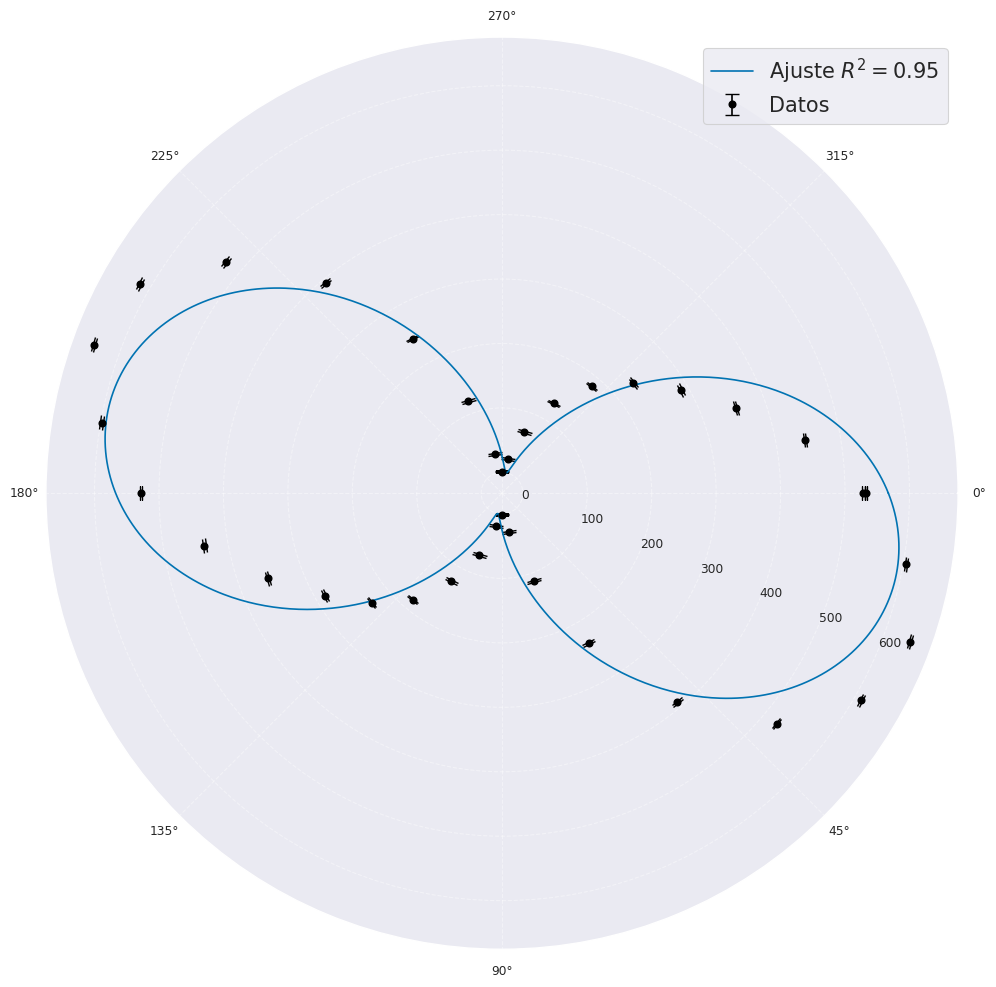

In [18]:
# Funcion ley de Malus
def Malus(theta, Io, alpha):
    return Io * np.cos(np.deg2rad(theta) + alpha)**2

# Calculo del R2
def R2(funcion, so_datos, si_datos, par):
    si_ajuste = funcion(so_datos, *par)
    RSS = np.sum((si_datos - si_ajuste)**2)
    TSS = np.sum((si_datos - np.mean(si_datos))**2)
    return 1 - RSS / TSS

theta = np.arange(0, 370, 10)

I = np.zeros(len(theta))
dI = np.zeros(len(theta))

for i,j in enumerate(theta):
    t, I_data = cargar_datos("Malus_lux", f"{j}grad")
    I[i] = np.mean(I_data)
    dI[i] = np.std(I_data)

# Ajuste
param, cov = curve_fit(Malus, theta, I, sigma= dI, p0=(620, -1))
Io, alpha = param
dIo, dalpha = np.sqrt(np.diag(cov))

# Calculo del R2
r2 = R2(Malus, theta, I, (Io, alpha))

# Graficacion
theta_lins = np.linspace(0, 360, 1000)
fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(theta, I, yerr= dI, fmt='o', color='black', ecolor='black', capsize=5, label='Datos')
ax.plot(theta_lins, Malus(theta_lins, Io, alpha), label=rf'Ajuste $R^2 = {r2:.2f}$')
ax.set_xlabel("Grados (°)", fontsize=15)
ax.set_ylabel("Iluminancia (lx)", fontsize=15)
ax.grid(True)
ax.legend(fontsize= 14, loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig('Malus_cel.pdf', dpi=300)
plt.close()

theta_rad = np.deg2rad(theta)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10,10))
ax.errorbar(theta_rad, I, yerr= dI, fmt='o', color='black', ecolor='black', capsize=5, label='Datos')
ax.plot(np.deg2rad(theta_lins), Malus(theta_lins, Io, alpha), label=rf'Ajuste $R^2 = {r2:.2f}$')
ax.set_theta_zero_location("E")   # 0° sobre eje x
ax.set_theta_direction(-1)        # sentido horario
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='upper right', fontsize=15)
plt.tight_layout()
plt.show()
fig.savefig('Malus_cel_pol.pdf', dpi=300)
plt.close()


## Ley de Malus - Imagenes

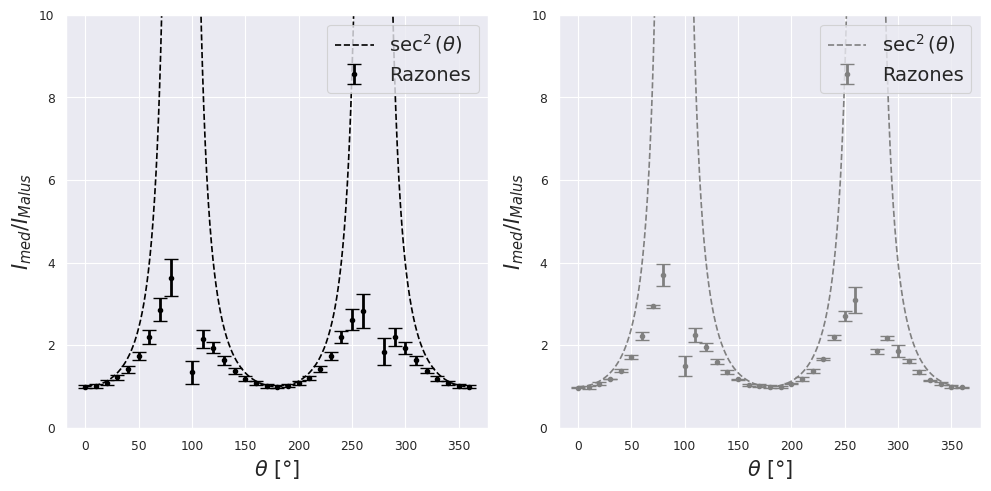

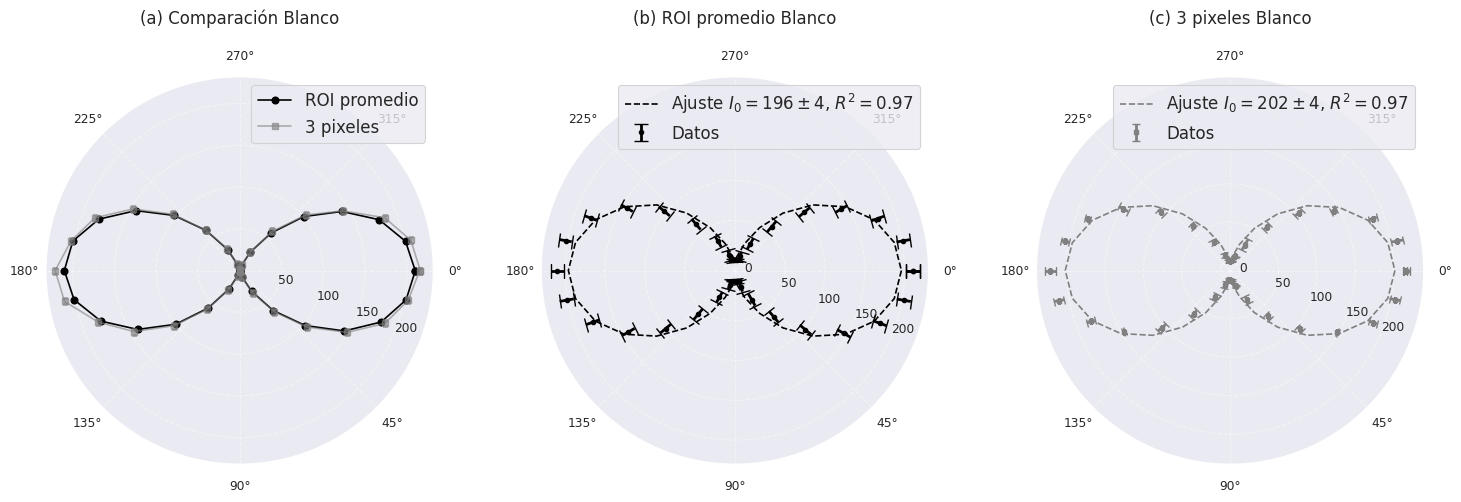

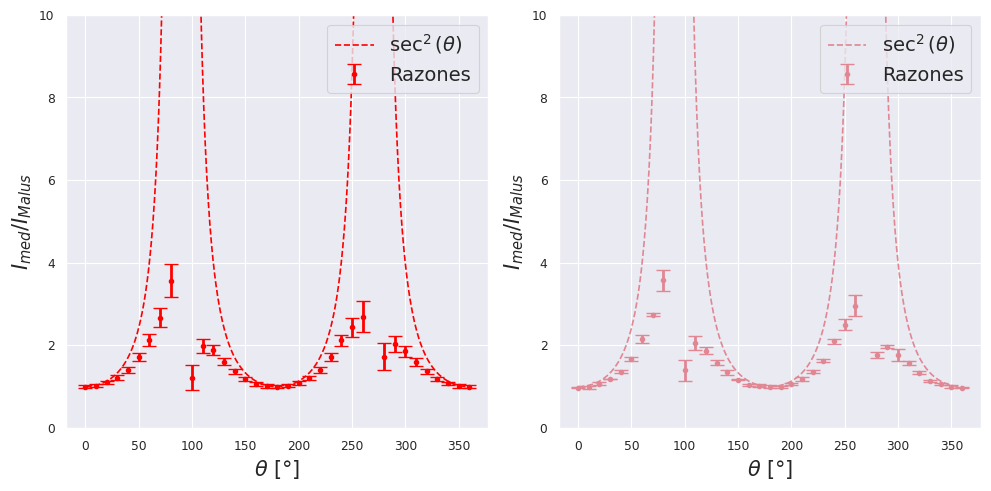

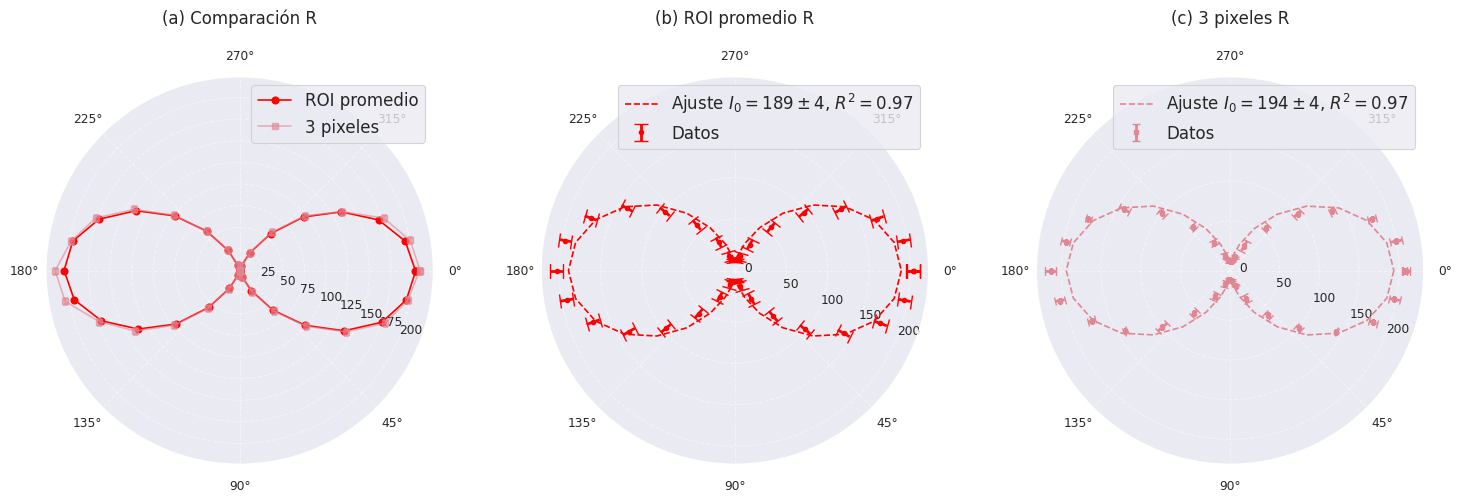

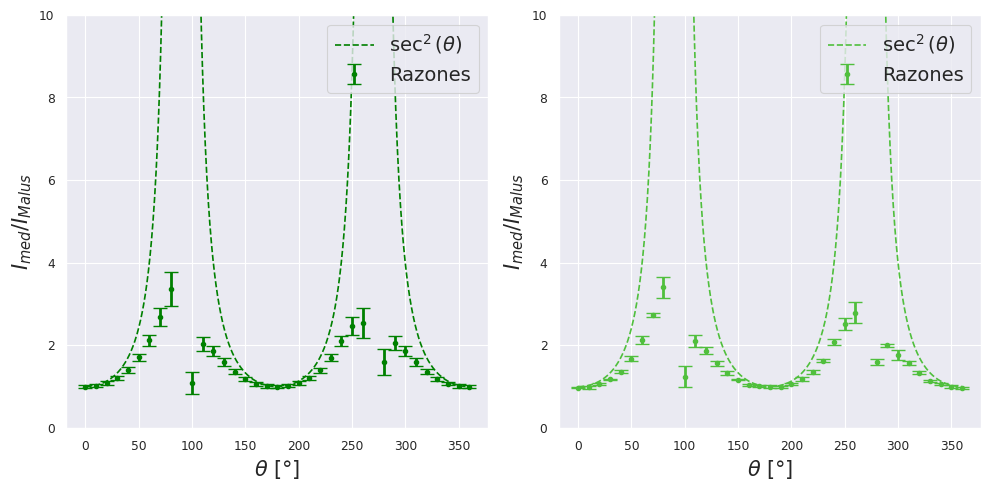

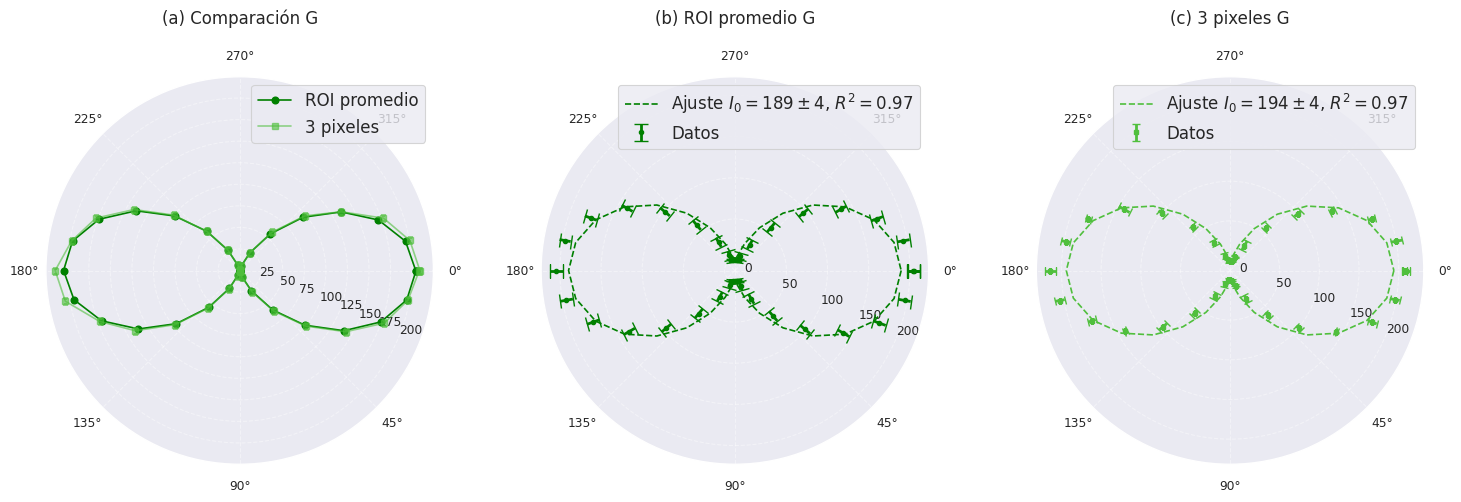

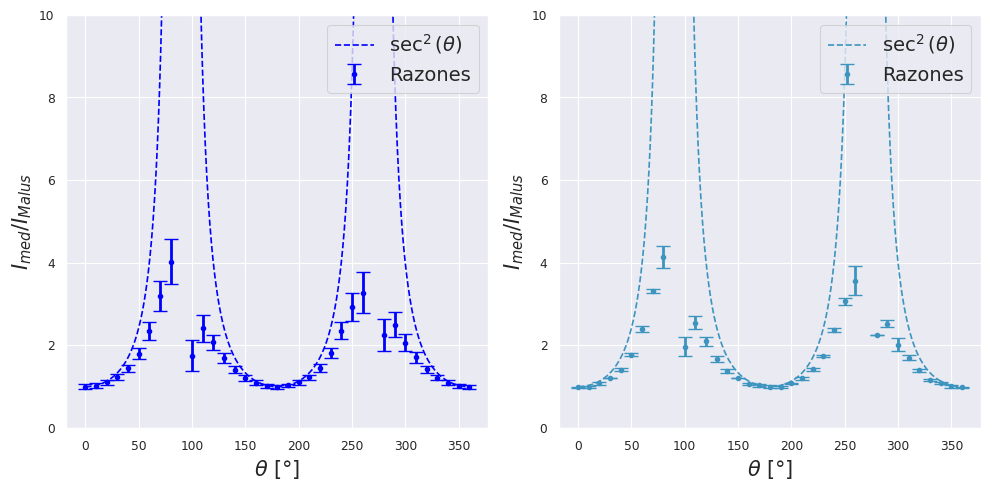

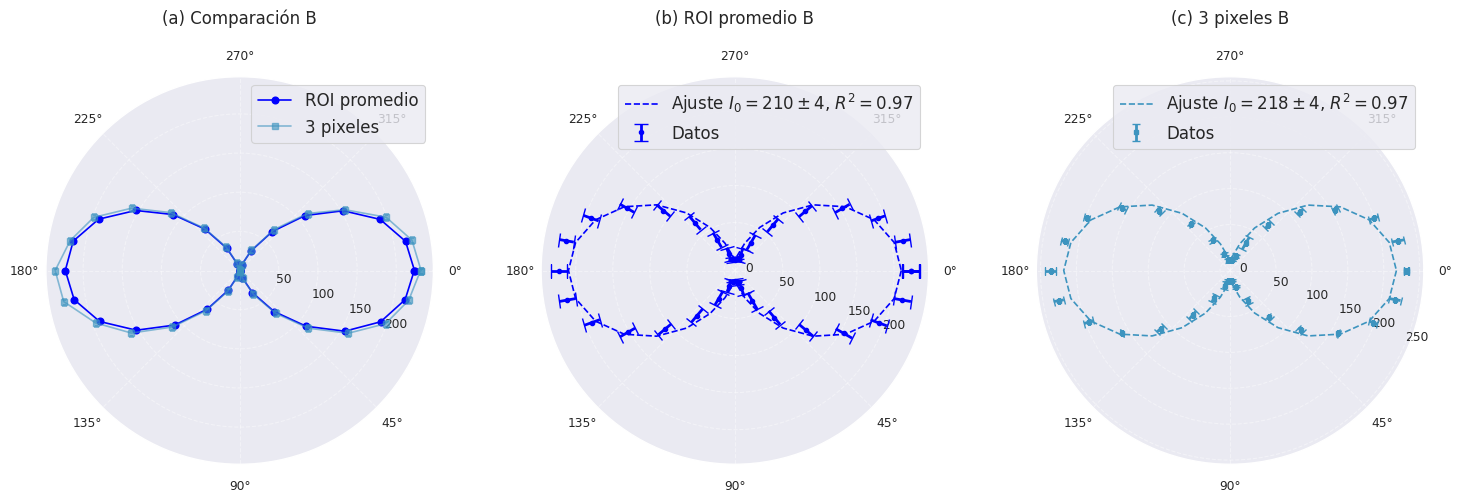

In [32]:
canales = ['Blanco', 'Rojo', 'Verde', 'Azul']
color_roi = {'Blanco':'black', 'Rojo':'red', 'Verde':'green', 'Azul':'blue'}
color_pix = {'Blanco':'grey', 'Rojo':'#E08793', 'Verde':'#50BF3D', 'Azul':'#3D94BF'}
canal_abrev = {'Blanco':'Blanco', 'Rojo':'R', 'Verde':'G', 'Azul':'B'}

def MalusImage(theta, Io):
    return Io * np.cos(theta)**2

def datos_imagenes(color):
    p = pd.read_csv(f"Practica6_datos/Malus_ROI/ROI_{color}.csv", sep=',')

    roi_mean = np.array(p['Mean(ROI)'])
    roi_std = np.array(p['StdDev(ROI)'])

    pix1 = np.array(p['Mean(pix1)'])
    pix2 = np.array(p['Mean(pix2)'])
    pix3 = np.array(p['Mean(pix3)'])

    pix_mean = np.array([np.mean([pix1[i], pix2[i], pix3[i]]) for i in range(len(pix1))])
    pix_std = np.array([np.std([pix1[i], pix2[i], pix3[i]]) for i in range(len(pix1))])

    return roi_mean, roi_std, pix_mean, pix_std

def graficar_polar(color):
    ang_deg = np.arange(0, 370, 10)
    ang_rad = np.deg2rad(ang_deg)
    roi_mean, roi_std, pix_mean, pix_std = datos_imagenes(color)

    # Razon entre los valores medidos y la ley de Malus
    Io_roi = np.max(roi_mean)
    Io_pix = np.max(pix_mean)

    ang_lins = np.linspace(0, 360, 1000)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.errorbar(ang_deg, roi_mean / MalusImage(ang_rad, Io_roi), yerr= roi_std / MalusImage(ang_rad, Io_roi), 
                 fmt='o', color=color_roi[color], ecolor=color_roi[color], 
                 elinewidth=2, markersize=3, capsize=5, label='Razones')
    ax1.plot(ang_lins, 1 / np.cos(np.deg2rad(ang_lins))**2, '--', color=color_roi[color], label=r'$\sec^2(\theta)$')
    ax1.set_xlabel(r'$\theta$ [°]', fontsize=15)
    ax1.set_ylabel(r'$I_{med}/I_{Malus}$', fontsize=15)
    ax1.set_ylim(0, 10)
    ax1.grid(True)
    ax1.legend(fontsize= 14, loc='upper right')

    ax2.errorbar(ang_deg, pix_mean / MalusImage(ang_rad, Io_pix), yerr= pix_std / MalusImage(ang_rad, Io_pix), 
                 fmt='o', color=color_pix[color], ecolor=color_pix[color], 
                 elinewidth=2, markersize=3, capsize=5, label='Razones')
    ax2.plot(ang_lins, 1 / np.cos(np.deg2rad(ang_lins))**2, '--', color=color_pix[color], label=r'$\sec^2(\theta)$')
    ax2.set_xlabel(r'$\theta$ [°]', fontsize=15)
    ax2.set_ylabel(r'$I_{med}/I_{Malus}$', fontsize=15)
    ax2.set_ylim(0, 10)
    ax2.grid(True)
    ax2.legend(fontsize= 14, loc='upper right')

    plt.tight_layout()
    plt.show()
    fig.savefig(f'razon_{color}.pdf', dpi=300)
    plt.close()
    
    # Correcciones de las intensidades reportadas por efecto de la camara
    roi_mean = roi_mean * np.cos(ang_rad)**2
    pix_mean = pix_mean * np.cos(ang_rad)**2

    # Ajustes
    par_roi, cov_roi = curve_fit(MalusImage, ang_rad, roi_mean)
    par_pix, cov_pix = curve_fit(MalusImage, ang_rad, pix_mean)
    Io_roi = par_roi[0]; Io_pix = par_pix[0]
    dIo_roi = np.sqrt(cov_roi[0][0])
    dIo_pix = np.sqrt(cov_pix[0][0])

    # Calculo coeficientes de determinacion R2
    r2_roi = R2(MalusImage, ang_rad, roi_mean, (Io_roi,))
    r2_pix = R2(MalusImage, ang_rad, pix_mean, (Io_pix,))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(15, 5))

    # Comparacion ROI y los tres pixeles
    ax1.plot(ang_rad, roi_mean, 'o-', color=color_roi[color], label='ROI promedio')
    ax1.plot(ang_rad, pix_mean, 's-', color=color_pix[color], alpha=0.6, label='3 pixeles')
    ax1.set_theta_zero_location("E")   # 0° sobre eje x
    ax1.set_theta_direction(-1)        # sentido horario
    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.legend(loc='upper right', fontsize=12)
    ax1.text(0.5, 1.15, f"(a) Comparación {canal_abrev[color]}", transform=ax1.transAxes, ha='center', va='center', fontsize=12)

    # Solo ROI
    ax2.plot(ang_rad, MalusImage(ang_rad, Io_roi), '--', color=color_roi[color], 
             label=rf'Ajuste $I_0 = {Io_roi:.0f} \pm {dIo_roi:.0f}$, $R^2 = {r2_roi:.2f}$')
    ax2.errorbar(ang_rad, roi_mean, yerr= roi_std, fmt='o', color=color_roi[color], ecolor=color_roi[color], elinewidth=2, markersize=3, capsize=5, label='Datos')
    ax2.set_theta_zero_location("E")   # 0° sobre eje x
    ax2.set_theta_direction(-1)        # sentido horario
    ax2.grid(True, linestyle='--', alpha=0.4)
    ax2.legend(loc='upper right', fontsize=12)
    ax2.text(0.5, 1.15, rf"(b) ROI promedio {canal_abrev[color]}", transform=ax2.transAxes, ha='center', va='center', fontsize=12)

    # Solo pixeles
    ax3.plot(ang_rad, MalusImage(ang_rad, Io_pix), '--', color=color_pix[color], 
             label=rf'Ajuste $I_0 = {Io_pix:.0f} \pm {dIo_pix:.0f}$, $R^2 = {r2_pix:.2f}$')
    ax3.errorbar(ang_rad, pix_mean, yerr= pix_std, fmt='s', color=color_pix[color], ecolor=color_pix[color], elinewidth=2, markersize=3, capsize=3, label='Datos')
    ax3.set_theta_zero_location("E")   # 0° sobre eje x
    ax3.set_theta_direction(-1)        # sentido horario
    ax3.grid(True, linestyle='--', alpha=0.4)
    ax3.legend(loc='upper right', fontsize=12)
    ax3.text(0.5, 1.15, rf"(c) 3 pixeles {canal_abrev[color]}", transform=ax3.transAxes, ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.subplots_adjust(top=0.85)
    plt.savefig(f"Malus_{color}.pdf", dpi=300)
    plt.show()


for color in canales:
    graficar_polar(color)
